In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [32]:
import pathlib

train_dir = pathlib.Path("./train/")

test_dir = pathlib.Path("./test/")

In [33]:
image_count = len(list(train_dir.glob('*/*.jpg')))
print(image_count)

1156


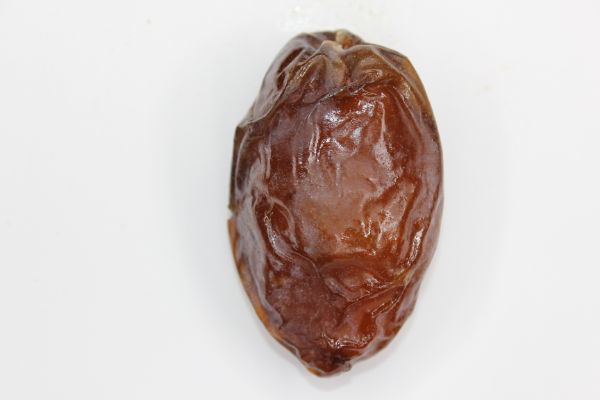

In [34]:
medjool = list(train_dir.glob('Medjool/*'))
PIL.Image.open(str(medjool[0]))

In [35]:
batch_size = 32
img_height = 180
img_width = 180

In [36]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1156 files belonging to 9 classes.
Using 925 files for training.


In [37]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1156 files belonging to 9 classes.
Using 231 files for validation.


In [38]:
class_names = train_ds.class_names
print(class_names)

['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


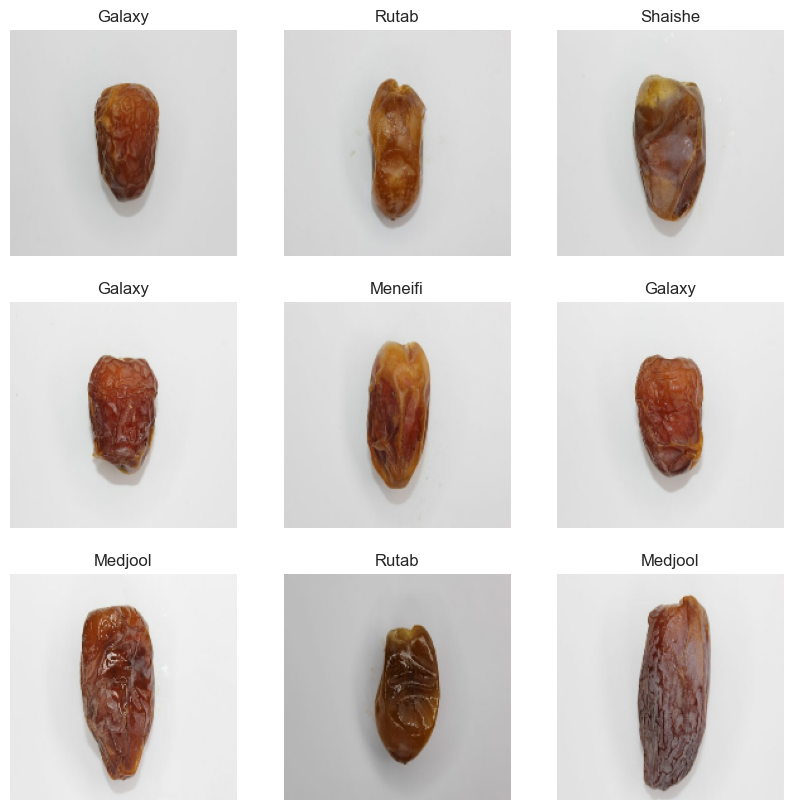

In [39]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [40]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [42]:
normalization_layer = layers.Rescaling(1./255)

In [43]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0070447964 0.8862746


In [44]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [47]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
29/29 [==============================] - 18s 555ms/step - loss: 2.3175 - accuracy: 0.1989 - val_loss: 1.9405 - val_accuracy: 0.3680
Epoch 2/10
29/29 [==============================] - 16s 549ms/step - loss: 1.4769 - accuracy: 0.4605 - val_loss: 1.1451 - val_accuracy: 0.5801
Epoch 3/10
29/29 [==============================] - 15s 537ms/step - loss: 0.9261 - accuracy: 0.6551 - val_loss: 0.7933 - val_accuracy: 0.7013
Epoch 4/10
29/29 [==============================] - 17s 589ms/step - loss: 0.6777 - accuracy: 0.7568 - val_loss: 0.6868 - val_accuracy: 0.7879
Epoch 5/10
29/29 [==============================] - 16s 541ms/step - loss: 0.5377 - accuracy: 0.8032 - val_loss: 0.5502 - val_accuracy: 0.8268
Epoch 6/10
29/29 [==============================] - 14s 497ms/step - loss: 0.3680 - accuracy: 0.8789 - val_loss: 0.4925 - val_accuracy: 0.8528
Epoch 7/10
29/29 [==============================] - 15s 505ms/step - loss: 0.3561 - accuracy: 0.8692 - val_loss: 0.4944 - val_accuracy: 0.8312

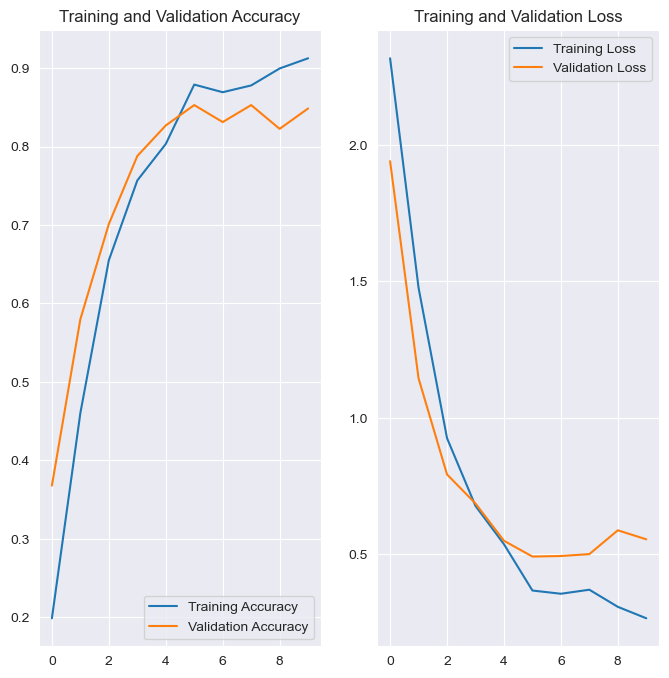

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
        input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

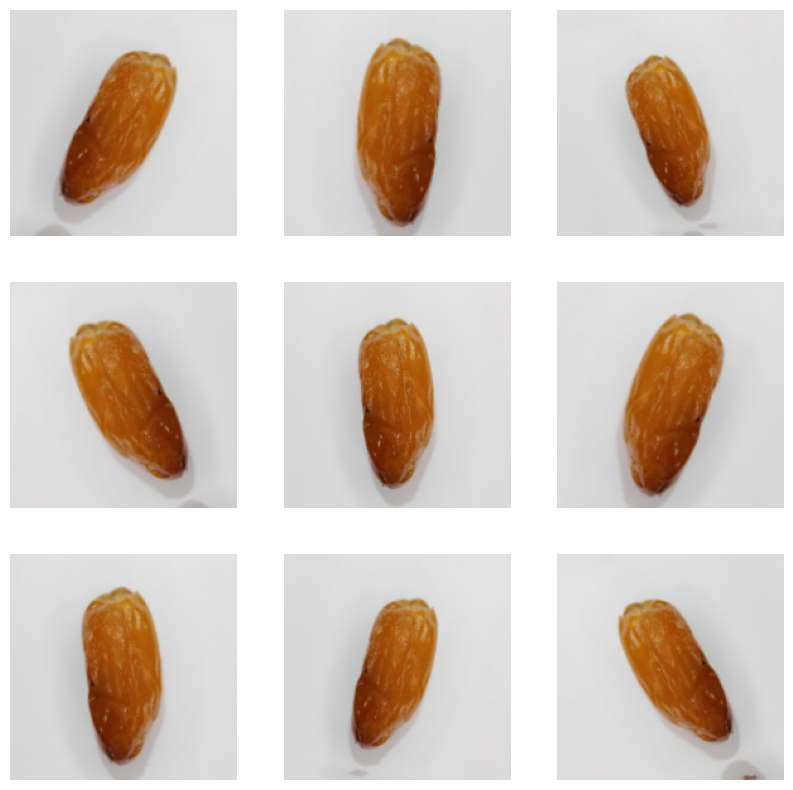

In [50]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [51]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [54]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
29/29 [==============================] - 27s 712ms/step - loss: 2.2705 - accuracy: 0.1514 - val_loss: 2.1325 - val_accuracy: 0.2554
Epoch 2/15
29/29 [==============================] - 21s 743ms/step - loss: 1.8688 - accuracy: 0.3286 - val_loss: 1.5993 - val_accuracy: 0.2771
Epoch 3/15
29/29 [==============================] - 23s 792ms/step - loss: 1.3113 - accuracy: 0.5319 - val_loss: 1.0095 - val_accuracy: 0.6190
Epoch 4/15
29/29 [==============================] - 23s 783ms/step - loss: 0.9496 - accuracy: 0.6486 - val_loss: 0.7406 - val_accuracy: 0.7749
Epoch 5/15
29/29 [==============================] - 21s 726ms/step - loss: 0.8102 - accuracy: 0.7189 - val_loss: 0.9377 - val_accuracy: 0.7013
Epoch 6/15
29/29 [==============================] - 20s 699ms/step - loss: 0.6990 - accuracy: 0.7492 - val_loss: 0.7079 - val_accuracy: 0.7965
Epoch 7/15
29/29 [==============================] - 25s 861ms/step - loss: 0.6275 - accuracy: 0.7859 - val_loss: 0.5312 - val_accuracy: 0.8052

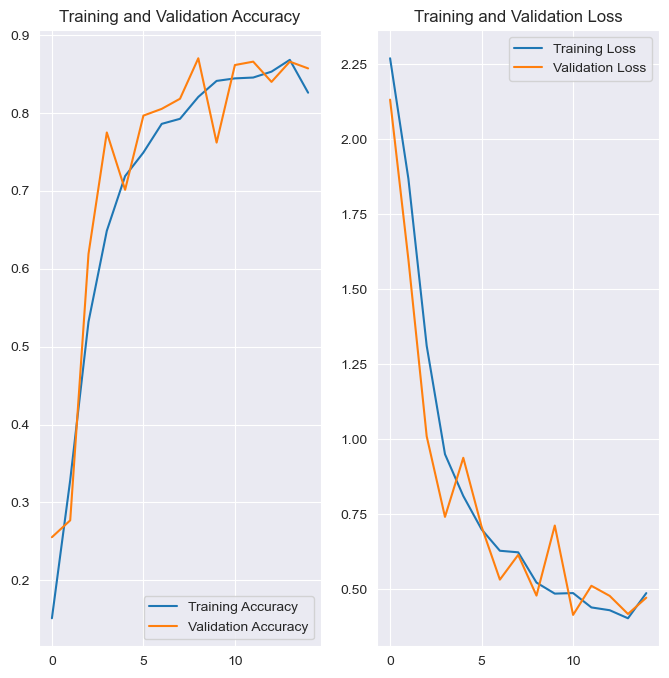

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [56]:
img = list(test_dir.glob('Medjool/*'))
img = PIL.Image.open(str(img[21])).resize((180, 180))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 334ms/step
This image most likely belongs to Medjool with a 94.11 percent confidence.


In [65]:
predicted = []
true_labels = []
dirs = list(test_dir.glob('*'))

for d in range(len(dirs)):
    dir = dirs[d]
    predicted.append([])

    for image in dir.glob('*/'):
        image = PIL.Image.open(image).resize((180, 180))
        img_array = tf.keras.utils.img_to_array(image)
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        result = np.argmax(score)
        predicted[d].append(result)
        true_labels.append(d)

1/1 [==============================] - 0s 44ms/step


In [66]:
confusion_matrix = []
for l in range(len(predicted)):
    confusion_matrix.append([])
    for i in range(len(predicted)):
        confusion_matrix[l].append(predicted[l].count(i))

In [67]:
flat_predicted = [item for sublist in predicted for item in sublist]

print("Accuracy:", accuracy_score(true_labels, flat_predicted))

Accuracy: 0.8386454183266933


In [70]:
print(classification_report(true_labels, flat_predicted))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        53
           1       0.76      0.93      0.83        57
           2       0.95      0.85      0.90        41
           3       0.68      0.76      0.72        70
           4       0.90      0.67      0.77        54
           5       0.84      0.84      0.84        44
           6       0.88      0.96      0.92        52
           7       0.88      0.80      0.84        80
           8       0.82      0.78      0.80        51

    accuracy                           0.84       502
   macro avg       0.85      0.84      0.84       502
weighted avg       0.85      0.84      0.84       502



<AxesSubplot:>

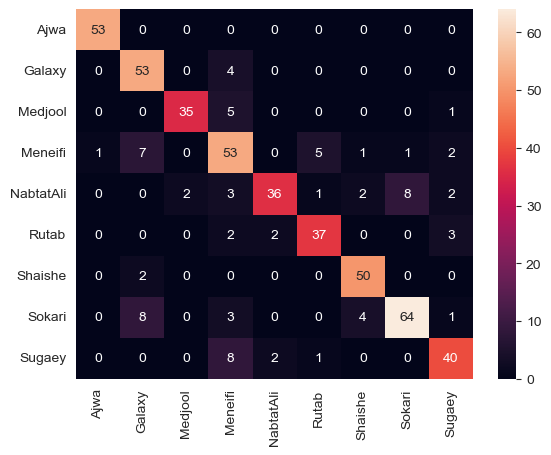

In [69]:
cm_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
sns.heatmap(cm_df, annot=True)